# UMAP for Data Exploration

## Env Preparation

In [1]:
import os
import sys
os.chdir('/app/')
print(os.getcwd())
from os.path import join as JP
sys.path.append(os.getcwd())
sys.path.append(JP(os.getcwd(),'utils'))
sys.path.append(JP(os.getcwd(),'scripts'))

/app


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# %matplotlib notebook
%matplotlib inline
np.set_printoptions(precision=3)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
import pickle
from pprint import pprint
from collections import defaultdict

from utils.nlp_utils import preproces
from utils.general import parse_yaml, ensure_directories

from scripts.catalog import (
    Catalog, Document, Corpus,
    load_catalog, load_corpus)

config = parse_yaml('config.yaml')
paths = config['paths']
ensure_directories(paths)

## Data

In [68]:
df = data = pd.read_csv(JP('data','bbc-text-processed.csv')).iloc[:,1:]
data.head()

,category,text,lenght,processed
0,tech,tv future in the hands of viewers with home th...,806,tv future hand viewer system plasma high defin...
1,business,worldcom boss left books alone former worldc...,332,left book ebber accuse oversee 11bn fraud acco...
2,sport,tigers wary of farrell gamble leicester say ...,270,wary farrell gamble rush make bid decide switc...
3,sport,yeading face newcastle in fa cup premiership s...,390,yeade face premiership face trip leader yeade ...
4,entertainment,ocean s twelve raids box office ocean s twelve...,287,raid ocean crime go number office chart take w...


## TFIDF

In [5]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
EMBED_SIZE = 10000        # TODO: Increase
NUM_CLUSTERS = data['category'].nunique()
WORDS_PER_CLUSTER = None
print(NUM_CLUSTERS)

5


In [7]:
vectorizer = TfidfVectorizer(
    min_df=.05,
    max_df=.9,
    norm='l2',
    use_idf=True,
    smooth_idf=True,
    max_features=EMBED_SIZE,
    ngram_range=(1,3),
    lowercase=True,
    stop_words=stopwords.words('english'))

## Moving to a Catalog Format

In [8]:
documents = [Document() for i in range(data.shape[0])]
for d in range(len(documents)):
    documents[d].processed_text = data['processed'][d]

In [9]:
catalog = Catalog()
catalog.documents = documents

In [10]:
_ = catalog.collect_corpus(attr='processed_text', form=list)
tfidf = catalog.to_matrix(
    vectorizer=vectorizer,
    modelname='TFIDF',
    max_docs=None)
print(tfidf.representation.shape)
tfidf.representation.head()

(2225, 461)


,able,accept,access,accord,account,accuse,act,action,add,admit,...,week,weekend,win,winner,woman,work,world,write,year,young
0,0.000,0.000,0.000,0.037,0.000,0.000,0.000,0.000,0.027,0.000,...,0.000,0.000,0.000,0.000,0.000,0.029,0.000,0.000,0.038,0.000
1,0.000,0.000,0.000,0.000,0.000,0.150,0.000,0.000,0.000,0.299,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.239,0.066,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.115,0.000,0.000,0.000,0.000,0.000,0.000,...,0.093,0.315,0.087,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA

In [48]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components=3)
pca_output = pca.fit_transform(tfidf.representation.values)
print('Singular Values = ', pca.singular_values_)
print('Explaiend Varaince = ', pca.explained_variance_)
print('Explaiend Varaince Ratio = ', pca.explained_variance_ratio_)

Singular Values =  [8.177 7.244 6.859]
Explaiend Varaince =  [0.03  0.024 0.021]
Explaiend Varaince Ratio =  [0.033 0.026 0.023]


In [71]:
df = df.assign(pca1=pca_output[:,0], pca2=pca_output[:,1], pca3=pca_output[:,2])

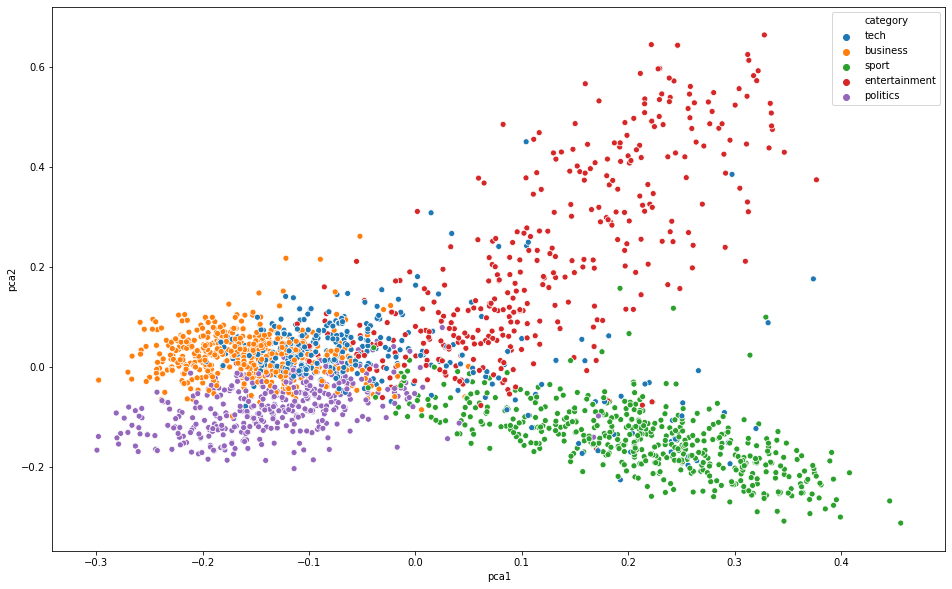

In [72]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=df.pca1, y=df.pca2, hue=data.category)

In [86]:
fig = px.scatter_3d(df, x='pca1', y='pca2', z='pca3', color='category')
fig.update_traces(marker=dict(size=3))
fig.show()

### PCA + Scaling
I am not sure if normalization of counts makes any sense

In [83]:
pca_ = pca.fit_transform(StandardScaler().fit_transform(tfidf.representation.values))
df = df.assign(pca_sc1=pca_[:,0], pca_sc2=pca_[:,1], pca_sc3=pca_[:,2])

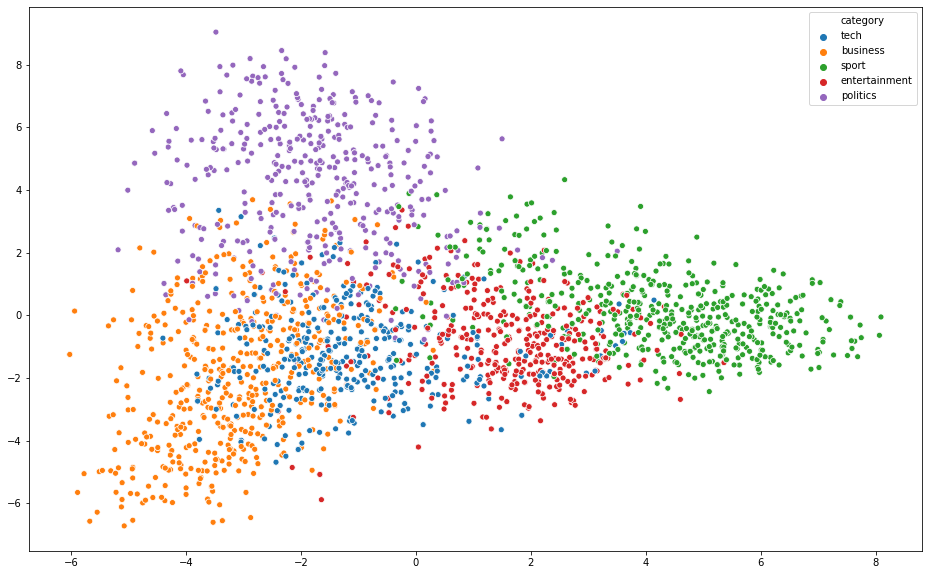

In [93]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=pca_[:,0], y=pca_[:,1], hue=data.category)

In [88]:
fig = px.scatter_3d(df, x='pca_sc1', y='pca_sc2', z='pca_sc3', color='category')
fig.update_traces(marker=dict(size=3))
fig.show()

## Truncated SVD
Truncated SVD is prefered for sparse input matrices

In [89]:
from sklearn.decomposition import TruncatedSVD

In [96]:
svd = TruncatedSVD(n_components=3)
svd_output = svd.fit_transform(tfidf.representation.values)
df = df.assign(svd_1=svd_output[:,0], svd_2=svd_output[:,1], svd_3=svd_output[:,2])

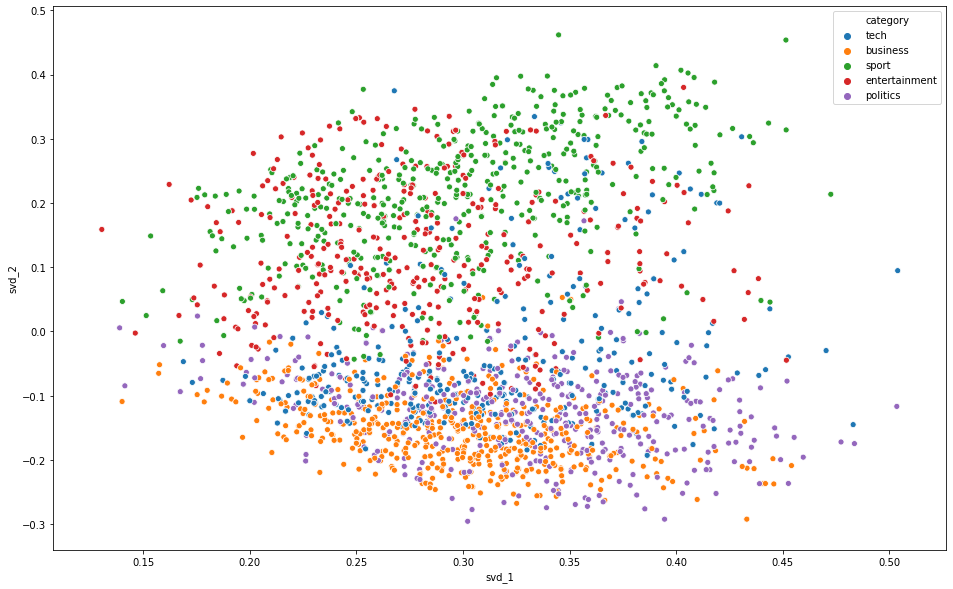

In [98]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=df.svd_1, y=df.svd_2, hue=data.category)

In [99]:
fig = px.scatter_3d(df, x='svd_1', y='svd_2', z='svd_3', color='category')
fig.update_traces(marker=dict(size=3))
fig.show()

# T-SNE without PCA

In [104]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1)
%time tsne_ = tsne.fit_transform(tfidf.representation.values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.051s...
[t-SNE] Computed neighbors for 2225 samples in 5.000s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.336560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.193405
[t-SNE] KL divergence after 1000 iterations: 1.233374
CPU times: user 1min 35s, sys: 80 ms, total: 1min 35s
Wall time: 1min 36s


In [105]:
df = df.assign(tsne_1=tsne_[:,0], tsne_2=tsne_[:,1], tsne_3=tsne_[:,2])

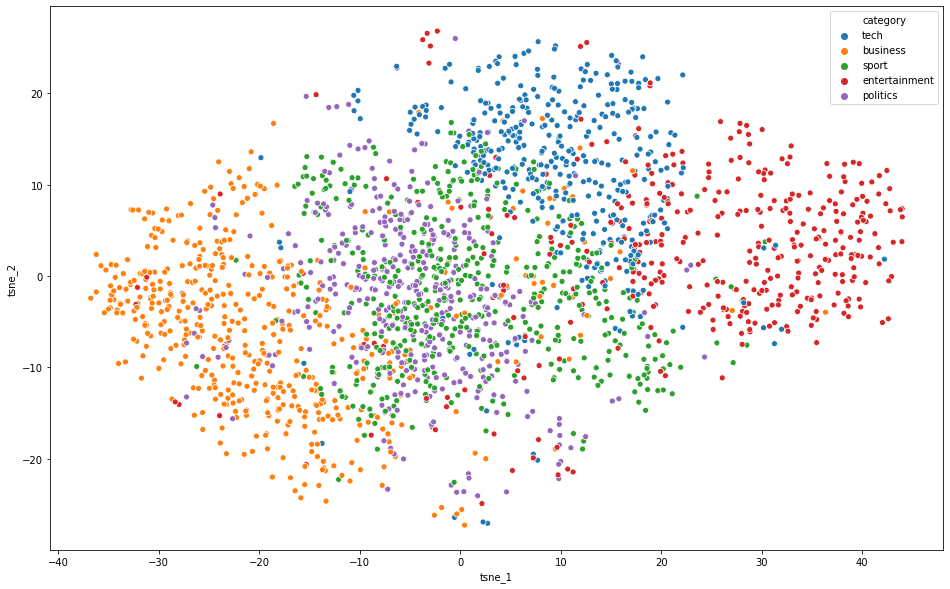

In [109]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=df.tsne_1, y=df.tsne_2, hue=data.category)
# sns.scatterplot(
#     x="X1", y="X2", hue=data.category, data=pd.DataFrame(X[:,0:2], columns=['X1', 'X2']))

In [108]:
fig = px.scatter_3d(df, x='tsne_1', y='tsne_2', z='tsne_3', color='category')
fig.update_traces(marker=dict(size=3))
fig.show()

# T-SNE with PCA

In [ ]:
tsne_pca_ = tsne.fit_transform(pca_output)
df = df.assign(tsne_sc_1=tsne_pca_[:,0], tsne_sc_2=tsne_pca_[:,1], tsne_sc_3=tsne_pca[:,2])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.002s...
[t-SNE] Computed neighbors for 2225 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.025642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.883015


In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=df.tsne_sc_1, y=df.tsne_sc_2, hue=data.category)

In [ ]:
fig = px.scatter_3d(df, x='tsne_sc_1', y='tsne_sc_2', z='tsne_sc_2', color='category')
fig.update_traces(marker=dict(size=3))
fig.show()

# T-SNE with PCA + Scaling

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.007s...
[t-SNE] Computed neighbors for 2225 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.633259
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.711166
[t-SNE] KL divergence after 1000 iterations: 0.793418


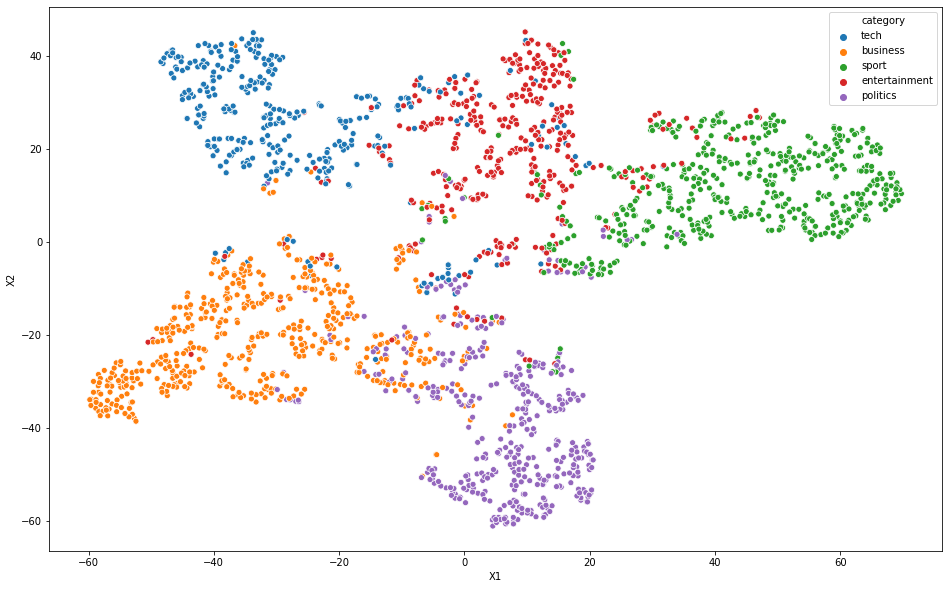

In [65]:
X = tsne_2.fit_transform(
    pca.fit_transform(
        StandardScaler().fit_transform(
            tfidf.representation.values)))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="X1", y="X2", hue=data.category, 
    data=pd.DataFrame(X[:,0:2], columns=['X1', 'X2']))

# T-SNE with Truncated SVD

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.001s...
[t-SNE] Computed neighbors for 2225 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.632778
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.118454
[t-SNE] KL divergence after 1000 iterations: 0.792431


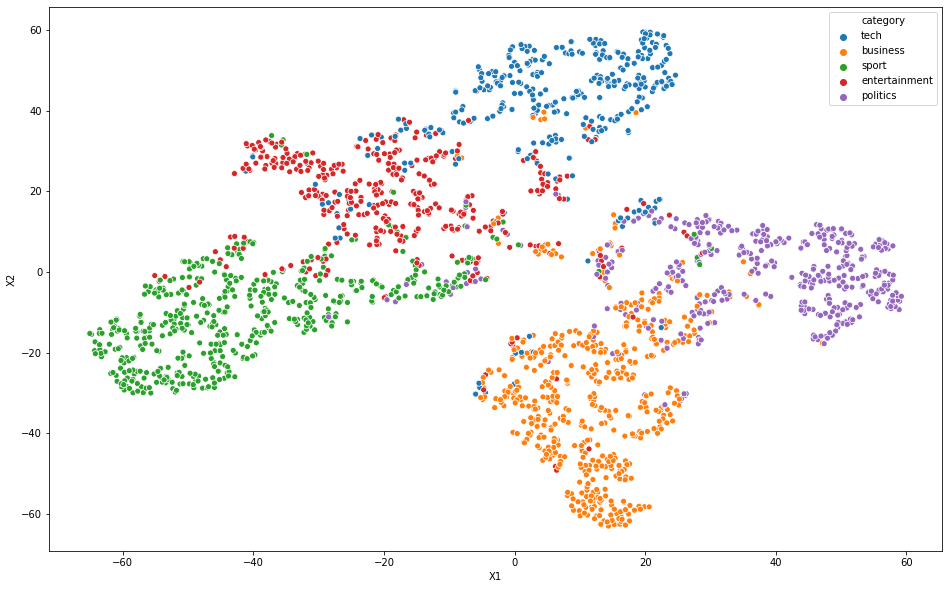

In [66]:
X = tsne_2.fit_transform(
    svd.fit_transform(
        StandardScaler().fit_transform(
            tfidf.representation.values)))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="X1", y="X2", hue=data.category, 
    data=pd.DataFrame(X[:,0:2], columns=['X1', 'X2']))

## UAMP

In [34]:
import umap

In [36]:
data['color'] = data.category.apply(lambda c: colormap[c])

In [13]:
embedding = umap.UMAP(
    n_neighbors=50,
    n_components=2,
    metric='cosine').fit_transform(tfidf.representation.values)

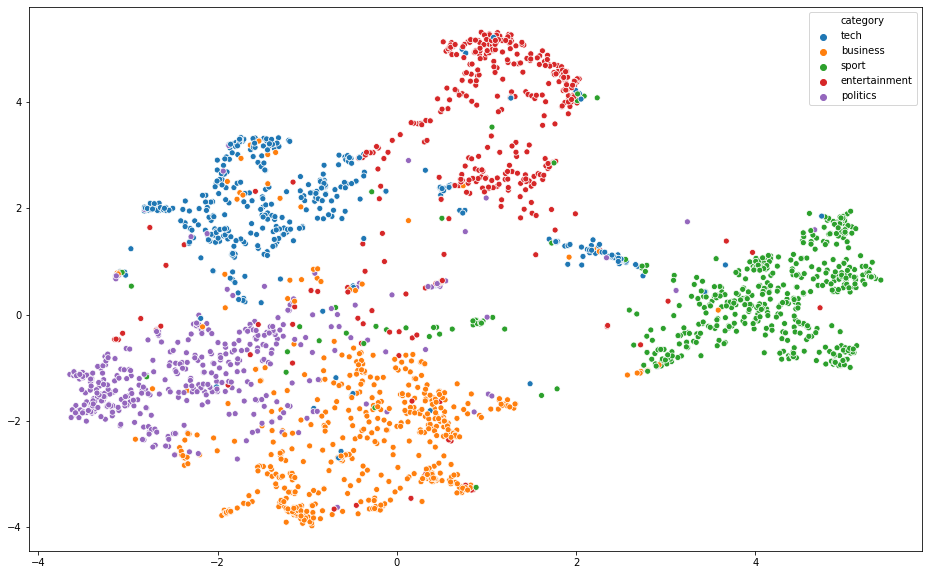

In [61]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=data.category)